# Neural Style Transfer

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

import os
import copy

In [3]:
# Detects if cuda is availaible for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(torch.cuda.is_available())

True


In [4]:

# Desired Size of the Output Image
imsize = (512,512) if torch.cuda.is_available() else (128,128)
 # Scale imported image and transform it into a tensor
loader = transforms.Compose([transforms.Resize(imsize),transforms.ToTensor()])
def image_loader(image_name):
    image = Image.open(image_name)
    # Fake batch dimension required to fit netowrk's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device,torch.float)

# Variable Initialization

In [5]:

# Loading of Images
style_img =image_loader("data/style-images/"+"spiderman.jpg")
content_img = image_loader("data/content-images/"+"taj_mahal.jpg")
print(style_img.size(), content_img.size())
    
assert style_img.size()==content_img.size(),"Style and Content Images must be of Same Size"

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


In [25]:
# Figures will be shown on creation
plt.ion()

# To show the tensor as a PIL Image
def show_img(tensor,title=None,num=0):
    # Reconverts into PIL Image
    unloader = transforms.ToPILImage()
    # Clone the tensor to not do changes on it 
    image = tensor.cpu().clone()
    # Remove the fake batch dimension
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    # Pause to wait for plots to update
    plt.pause(0.001)
    if num==1:
        return image
    

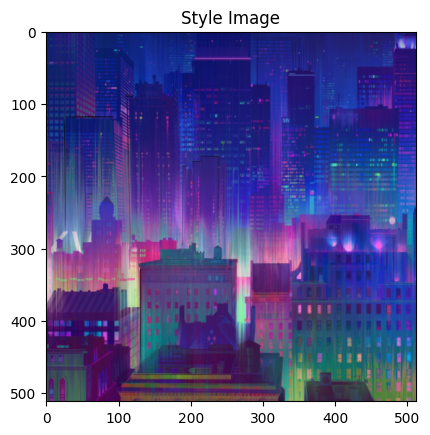

In [24]:
plt.figure()
show_img(style_img,title='Style Image')

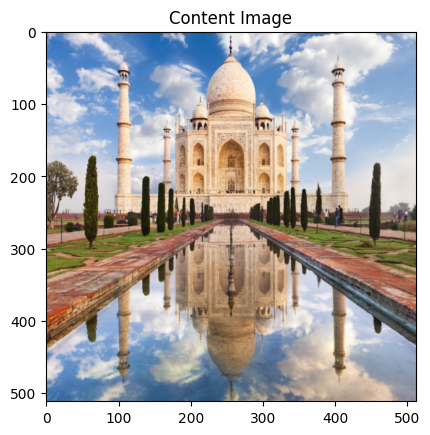

In [26]:
plt.figure()
show_img(content_img,title='Content Image')

Custom Class and NN Modules

Content Loss

In [9]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # Detach the target content from the tree used
        # To dynamically compute the gradient: This is a stated value
        self.target =target.detach()
        
    def forward(self,input):
        self.loss =F.mse_loss(input,self.target)
        return input

Style Loss

In [10]:
def gram_matrix(input):
    # Here a= batch size(=1), b = Number of Feature Maps
    # (c,d)= Dimensions of a Feature Map
    a,b,c,d =input.size()
    
    # Resizing the features of an Lth layer
    features =input.view(a*b,c*d)
    # Computing the Gram Product
    G =torch.mm(features, features.t())
    
    # We normalize the values of the gram matrix 
    # by dividing the number of element in each feature maps.
    
    # This normalization is to counteract the fact that final
    # matrices with a large N dimension yield larger values in the Gram matrix. 
    # These larger values will cause the first layers (before pooling layers) 
    # to have a larger impact during the gradient descent. 
    # But style features tends to be in deeper layers of the network.
    
    return G.div(a*b*c*d)

In [11]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # Detach the target content from the tree used
        # To dynamically compute the gradient: This is a stated value
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self,input):
        G= gram_matrix(input)
        self.loss =F.mse_loss(G,self.target)
        return input

# Importing the VGG19 Model

In [12]:
cnn =models.vgg19(pretrained=True).features.eval()

c:\Users\hardi\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hardi\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

In [13]:

cnn_mean = torch.tensor([0.485,0.456,0.406])
cnn_std = torch.tensor([0.229,0.224,0.225])

# Module to normalize input images
class Normalization(nn.Module):
    def __init__(self,mean,std):
        super(Normalization,self).__init__()
        # Reshape the mean and std so that they can directly work with image Tensor.
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)
        
    def forward(self,img):
        # Normalize img
        return (img-self.mean)/self.std

Add the Content Loss and Style Loss Layers immediately after the convolution layer they are Detecting

In [14]:
# Desired depth layers to compute content and style losses
content_default = ['conv_4']
style_default =['conv_1','conv_2','conv_3','conv_4','conv_5']

In [15]:
# Function to get model and losses
def get_style_model_losses(cnn,norm_mean,norm_std,style_img,content_img,content_layers=content_default,style_layers=style_default):
    # Using the normalization module
    cnn = copy.deepcopy(cnn)
    normalization =Normalization(norm_mean,norm_std).to(device)
    
    # Losses
    content_losses=[]
    style_losses=[]
    
    model = nn.Sequential(normalization)
    i=0
    
    for layer in cnn.children():
        if isinstance(layer,nn.Conv2d):
            i+=1
            name='conv_{}'.format(i)
        elif isinstance(layer,nn.ReLU):
            name='relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer,nn.MaxPool2d):
            name='pool_{}'.format(i)
        elif isinstance(layer,nn.BatchNorm2d):
            name='bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized Layer:{}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)
        
        # Add the Content Loss Layers
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i),content_loss)
            content_losses.append(content_loss)
        
        # Add the Style Loss Layers
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i),style_loss)
            style_losses.append(style_loss)
        
    for i in range(len(model)-1,-1,-1):
        if isinstance(model[i],ContentLoss) or isinstance(model[i],StyleLoss):
            break
    model =model[:(i+1)]
    
    return model, style_losses, content_losses
        

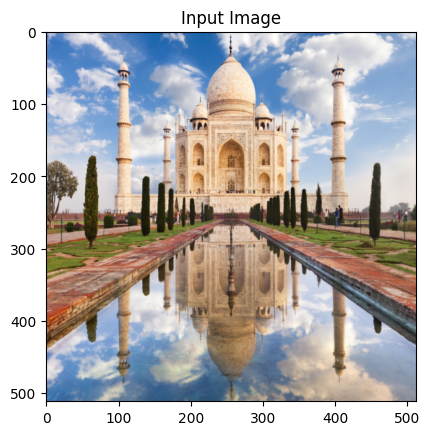

In [20]:
# Selecting the input Image 
# input_img =torch.randn(content_img.data.size(),device=device)
input_img = content_img.clone()
plt.figure()
show_img(input_img,title="Input Image")

# Gradient Descent
 In order to minimize Content and Style losses

In [21]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer
# In this case we are training input image to minimize 
# Content and Style Losses

# Neural Transfer

In [22]:
def run_style_transfer(cnn,norm_mean,norm_std,content_img,style_img,input_img,num_steps=600,style_weight=1000000,content_weight=1):
    print("Building the Style Transfer Model..")
    
    model,style_losses,content_losses=get_style_model_losses(cnn,norm_mean,norm_std,style_img,content_img)
    
    # We want to optimize the input and not the model parameters 
    input_img.requires_grad_(True)
    # Putting the model in evaluation mode
    model.eval()
    model.requires_grad_(False)
    
    optim = get_input_optimizer(input_img)
    
    print("Optimizing")
    
    
    run =[0]
    
    while run[0]<=num_steps:
            
        def closure():
            # Correct the values of the updated Input Image
            with torch.no_grad():
                input_img.clamp_(0,1)
            optim.zero_grad()
            model(input_img)
            style_score=0
            content_score=0
                
            # As per the formula to calculate loss using Style and Content Losses
            for sl in style_losses:
                style_score+=sl.loss
            for cl in content_losses:
                content_score+=cl.loss
                
            style_score*=style_weight
            content_score*=content_weight
                
            loss = style_score+content_score
            loss.backward()
                
            run[0]+=1
            if run[0]%50==0:
                print("run {}".format(run))
                print('Style Loss: {:4f} Content Loss: {:4f}\n'.format(style_score.item(),content_score.item()))
                print()
            return style_score+content_score

        optim.step(closure)
        
    with torch.no_grad():
        input_img.clamp_(0,1)
    return input_img
                    

In [27]:
def run(content_name,style_name,num=600):
    
    style_img =image_loader("data/style-images/"+style_name)
    content_img = image_loader("data/content-images/"+content_name)
    
    input_img = content_img.clone()
    cnn_mean = torch.tensor([0.485,0.456,0.406])
    cnn_std = torch.tensor([0.229,0.224,0.225])

    output =run_style_transfer(cnn,cnn_mean,cnn_std,content_img,style_img,input_img,num_steps=num)

    plt.figure()
    img=show_img(output,title='Output Image',num=1)
    img.save('data/Neural_Style_Transfer_Images/'+'Styled_'+content_name)
    

    plt.ioff()
    plt.show()
    


Building the Style Transfer Model..
Optimizing


c:\Users\hardi\anaconda3\envs\pytorch\lib\site-packages\torch\utils\_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


run [50]
Style Loss: 450.739624 Content Loss: 20.364483


run [100]
Style Loss: 223.902634 Content Loss: 23.706675


run [150]
Style Loss: 105.386742 Content Loss: 24.278210


run [200]
Style Loss: 45.223076 Content Loss: 23.038857


run [250]
Style Loss: 20.481647 Content Loss: 20.819683


run [300]
Style Loss: 11.679928 Content Loss: 18.464046


run [350]
Style Loss: 7.621946 Content Loss: 16.173115


run [400]
Style Loss: 5.059556 Content Loss: 14.619747


run [450]
Style Loss: 3.664612 Content Loss: 13.450226


run [500]
Style Loss: 2.691410 Content Loss: 12.532358


run [550]
Style Loss: 2.058484 Content Loss: 11.834268


run [600]
Style Loss: 1.652811 Content Loss: 11.328005




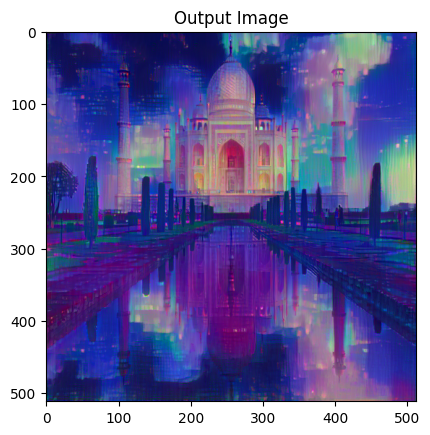

In [27]:
run("taj_mahal.jpg","spiderman.jpg")

Building the Style Transfer Model..


c:\Users\hardi\anaconda3\envs\pytorch\lib\site-packages\torch\utils\_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Optimizing
run [50]
Style Loss: 202.796021 Content Loss: 54.491673


run [100]
Style Loss: 63.555183 Content Loss: 51.131287


run [150]
Style Loss: 33.411983 Content Loss: 46.254871


run [200]
Style Loss: 19.706650 Content Loss: 40.990906


run [250]
Style Loss: 13.326143 Content Loss: 36.468174


run [300]
Style Loss: 9.759887 Content Loss: 32.405479


run [350]
Style Loss: 7.258208 Content Loss: 29.610727


run [400]
Style Loss: 5.393613 Content Loss: 27.359760


run [450]
Style Loss: 3.878278 Content Loss: 25.673006


run [500]
Style Loss: 3.042433 Content Loss: 24.514301


run [550]
Style Loss: 2.772084 Content Loss: 23.345076


run [600]
Style Loss: 1.942467 Content Loss: 22.552530




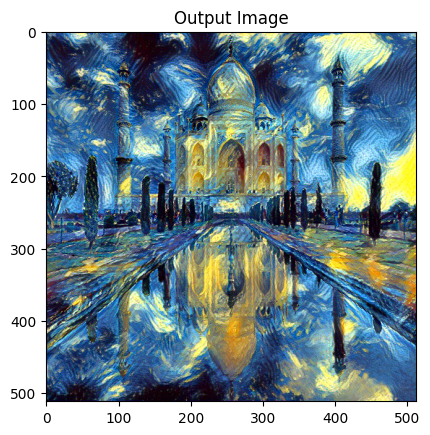

In [28]:
run("taj_mahal.jpg","vg_starry_night.jpg")

Building the Style Transfer Model..
Optimizing
run [50]
Style Loss: 132.889526 Content Loss: 14.712666


run [100]
Style Loss: 63.836575 Content Loss: 15.571577


run [150]
Style Loss: 30.999807 Content Loss: 13.120299


run [200]
Style Loss: 12.726943 Content Loss: 10.629597


run [250]
Style Loss: 5.986916 Content Loss: 8.746069


run [300]
Style Loss: 3.337310 Content Loss: 7.779401


run [350]
Style Loss: 1.893764 Content Loss: 7.257631


run [400]
Style Loss: 1.113584 Content Loss: 6.905699


run [450]
Style Loss: 0.751255 Content Loss: 6.644501


run [500]
Style Loss: 0.583875 Content Loss: 6.426670


run [550]
Style Loss: 0.509653 Content Loss: 6.267067


run [600]
Style Loss: 0.475209 Content Loss: 6.134182




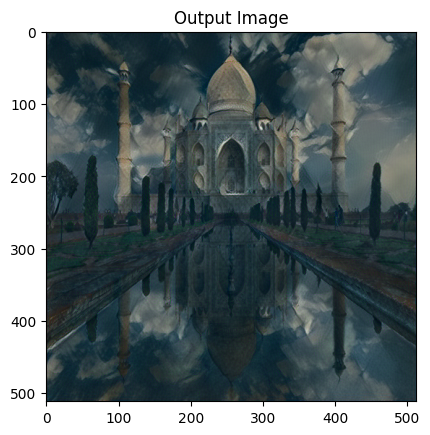

In [29]:
run("taj_mahal.jpg","picasso.jpg")

Building the Style Transfer Model..
Optimizing
run [50]
Style Loss: 201.155701 Content Loss: 49.058426


run [100]
Style Loss: 65.303993 Content Loss: 47.830772


run [150]
Style Loss: 31.633596 Content Loss: 45.611431


run [200]
Style Loss: 17.644220 Content Loss: 43.053062


run [250]
Style Loss: 11.298497 Content Loss: 40.437057


run [300]
Style Loss: 7.795417 Content Loss: 37.727814


run [350]
Style Loss: 5.703882 Content Loss: 35.329773


run [400]
Style Loss: 4.066145 Content Loss: 33.481697


run [450]
Style Loss: 3.012738 Content Loss: 32.043007


run [500]
Style Loss: 2.341885 Content Loss: 30.832644


run [550]
Style Loss: 1.810268 Content Loss: 29.850374


run [600]
Style Loss: 1.479047 Content Loss: 29.138367




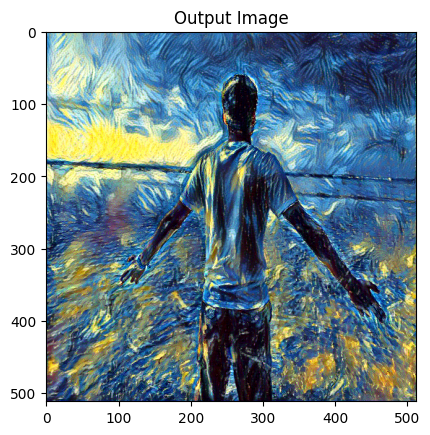

In [30]:
run("hardik.jpg","vg_starry_night.jpg")